**Introduction**  
EDA part was skipped, as it was already done in previous notebook.  
In this notebook will be reffered the regression problem. Will be used tree based models and ensemble models. Before applying any models data will be cleaned, prepared.  

Features description:
Date: (DD/MM/YYYY), date of record  
Time: (HH.MM.SS), time of record  
CO(GT): True hourly averaged concentration CO in mg/m^3 (reference analyzer)  
PT08.S1: (tin oxide) hourly averaged sensor response (nominally CO targeted)  
NMHC(GT): True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)  
PT08.S2: (titania) hourly averaged sensor response (nominally NMHC targeted)  
NOx(GT): True hourly averaged NOx concentration in ppb (reference analyzer)  
PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)  
NO2(GT): True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)  
PT08.S4: (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)  
PT08.S5: (indium oxide) hourly averaged sensor response (nominally O3 targeted)  
T: Temperature in °C  
RH: Relative Humidity (%)  
AH: Absolute Humidity  

Target variable:  
C6H6(GT): True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)  


---



Importing all necessary libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor, plot_importance

Loading Dataset

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Colab Notebooks/HW2/AirQualityUCI.csv'
data = pd.read_csv(file_path, sep=';')
data = data.iloc[:9357, :15]
data.head()

Mounted at /content/drive


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


**Data preprocessing**

Feature Date should be converted to suitable date format. Features CO(GT), C6H6(GT), T, RH, AH that are of type object, should be converted to type float64, as they are numeric.

In [ ]:
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
data[columns_to_convert] = data[columns_to_convert].replace(',', '.', regex=True).astype('float64')
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Time'] = pd.to_datetime(data['Time'], format='%H.%M.%S').dt.time

Replaced placeholder for Nan values in whole dataframe.

In [ ]:
data = data.replace(-200, np.nan)

We will drop from dataset feature: NMHC(GT), as 90 % of its values are missing.   
Every missing value in particular column will be imputed with value from the same column , previous day, same hour.

In [ ]:
data = data.drop(columns=['NMHC(GT)'])

In [ ]:
def fill_missing_with_previous_day(data):
    data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour

    for col in data.columns:
        if col not in ['Date', 'Time', 'Hour']:
            data[col] = data.groupby('Hour')[col].fillna(method='ffill')

    data = data.drop(columns=['Hour'])
    return data
data = fill_missing_with_previous_day(data)

<ipython-input-6-a13c0f254ec3>:6: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  data[col] = data.groupby('Hour')[col].fillna(method='ffill')
<ipython-input-6-a13c0f254ec3>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data.groupby('Hour')[col].fillna(method='ffill')


Also it can happen that there was not a specific value registered for some feature at specific hour at the very beginning, so there will no be performed any filling for such values, and they will remain Nans. So we need to complete filling with another strategy, the missing value will be filled with value of the previous hour within same feature.

In [ ]:
def fill_missing_with_previous_hour(data):
    data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour
    for col in data.columns:
        if col not in ['Date', 'Time', 'Hour']:
            data[col] = data.groupby('Date')[col].fillna(method='ffill')
    data = data.drop(columns=['Hour'])
    return data

data = fill_missing_with_previous_hour(data)

<ipython-input-7-33484eb1fa4a>:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  data[col] = data.groupby('Date')[col].fillna(method='ffill')
<ipython-input-7-33484eb1fa4a>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data.groupby('Date')[col].fillna(method='ffill')


Though, it is not required to rescale , standardize features(because we are going to use decision tree regressors, random forest regressors, XGBoost regressors in this notebook), will still be applied standardization to all our numerical features in dataset. So, to fully complete this stage of data preprocessing.

In [ ]:
independent_features = data.drop(columns=['C6H6(GT)', "Date", "Time"])
data[independent_features.columns] = (independent_features - independent_features.mean()) / independent_features.std()

To preserve dependencies of target feature from time features, like Date and Time , will be applied transformations to them: will be extracted the hour of recording in specific feature and will be extracted every recording's month (will be used one hot encoding, will be added 12 new according columns, each of them will represent particular month).

In [ ]:
data['Hour'] = pd.to_datetime(data['Time'].astype(str)).dt.hour
data['Month'] = pd.to_datetime(data['Date']).dt.month
month_dummies = pd.get_dummies(data['Month'], prefix='Month')
data = pd.concat([data, month_dummies], axis=1)

<ipython-input-9-4d0676041347>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Hour'] = pd.to_datetime(data['Time'].astype(str)).dt.hour


In [ ]:
data = data.drop(columns=['Month', "Date", "Time"])

Now, as the data is prepared models can be applied.

**Modeling**  
Preparing train and test sets

In [ ]:
X = data.drop('C6H6(GT)', axis=1)
y = data['C6H6(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Will be used for models perfomance evaluation MAE error because:    
1) gives us the error in the same units in which target variable is measured(easy to interpret such metric of accuracy);  
2) MAE was chosen because in previous notebook linear regression models were also assesed with MAE metric. Choosing the same metric will allow us to freely compare models from current and previous notebooks.  
MAE will also be used during models training, to find best splits.

Also during models perfomance evaluation will be used R^2 score. It was used previously for linear regression models. It tells us target variable variance percentage that is explained by our model.

Previous work results, there were two linear regression models:  
The first one had R^2: 0.9996 and MAE: 0.1138.  
The second one had R^2: 0.8256 and MAE: 2.2727.  
The first model used feature "PT08.S2(NMHC)" , the second one did not. The feature "PT08.S2(NMHC)" had extremely high linear correlation with target variable C6H6(GT), correlation value was 0.98.  
In this notebook for Decision Tree models will be firstly used full dataset (with feature "PT08.S2(NMHC)"), then will be trained Decision Tree models on dataset without feature "PT08.S2(NMHC)". For all other models: Random Forest regressor and XGBoost regressor will be used dataset without feature "PT08.S2(NMHC)".

**Decision Tree Regressor**

Defining function for training and testing Decision Tree regressor.

In [ ]:
def train_test_Decision_Tree(X_train, X_test, y_train, y_test, max_depth):
  dtr = DecisionTreeRegressor(criterion="absolute_error", max_depth=max_depth)
  dtr.fit(X_train, y_train)

  y_pred = dtr.predict(X_test)
  mae = mean_absolute_error(y_test, y_pred)
  print(f"Mean Absolute Error (MAE): {mae}")
  r2 = r2_score(y_test, y_pred)
  print(f"R² Score: {r2}")

  return dtr

In [ ]:

dtr1 = train_test_Decision_Tree(X_train, X_test, y_train, y_test, 3)

Mean Absolute Error (MAE): 0.9672542735042736
R² Score: 0.9437455037829594


Despite depth of the tree is low (is only 3), the model did very well on test set. The percentage of variance that our model explains is high , equals to 94%. And MAE metric is pretty low, equal to 0.96.
This model is a little bit worse than corresponding linear model (referred above as first linear model).

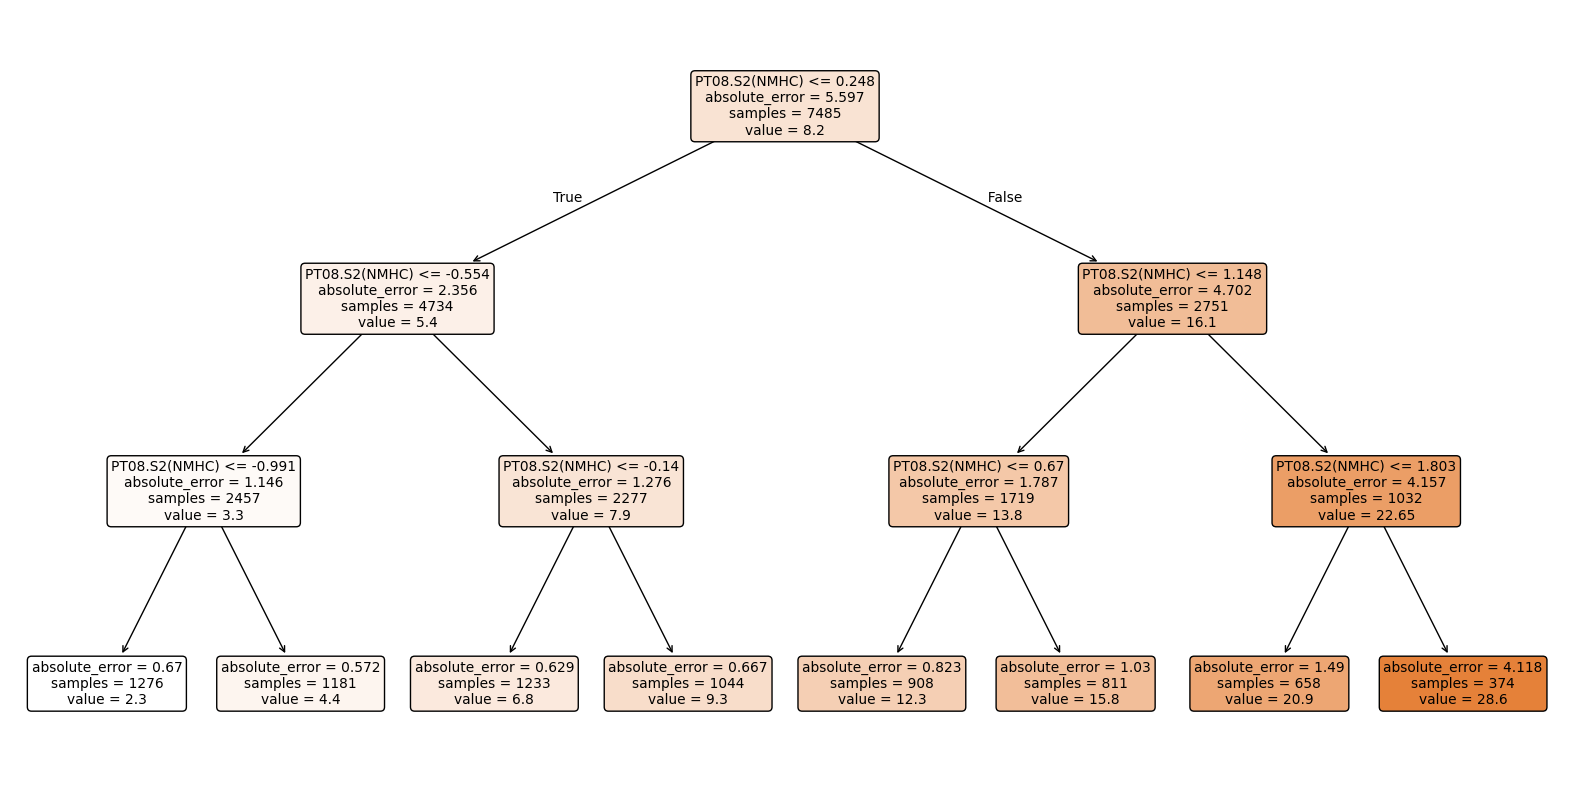

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(dtr1, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

The only feature model used in each split is "PT08.S2(NMHC)". It was seen during EDA in previous notebook, that there is strong linear relation between target variable and "PT08.S2(NMHC)", and it is clear that decision tree captured this dependency and successfully used it. So, we can conlude that feature "PT08.S2(NMHC)" is very important in predicting target variable.   
Let's train deeper tree on same dataset and investigate feature importance of it. Interesting to check whether deeper tree will be also relying only on feature  "PT08.S2(NMHC)" or not.

In [ ]:
dtr2 = train_test_Decision_Tree(X_train, X_test, y_train, y_test, 15)

Mean Absolute Error (MAE): 0.02596153846153848
R² Score: 0.9973993520551808


Can be seen that increase in hyperparameter "maximum depth" (from value of 3 , to value of 15) gave boost to our model. Comparing to previous Decision Tree Regressor, the MAE error decreased a lot, and R^2 score became much closer to 1. The generalization is very good, as test error MAE is very small , equal only to 0.01. Can be seen that MAE for this decision tree regressor is almost 10 times lower than for the best linear regression model. R^2 score is exceptionally high, equal to 99.97%. R^2 score is a little bit higher than for the best linear regression model. Overall, can be noted that an increase in maximum allowed depth that tree can reach, has improved model perfomance. Now, the model perfectly describes target variable.

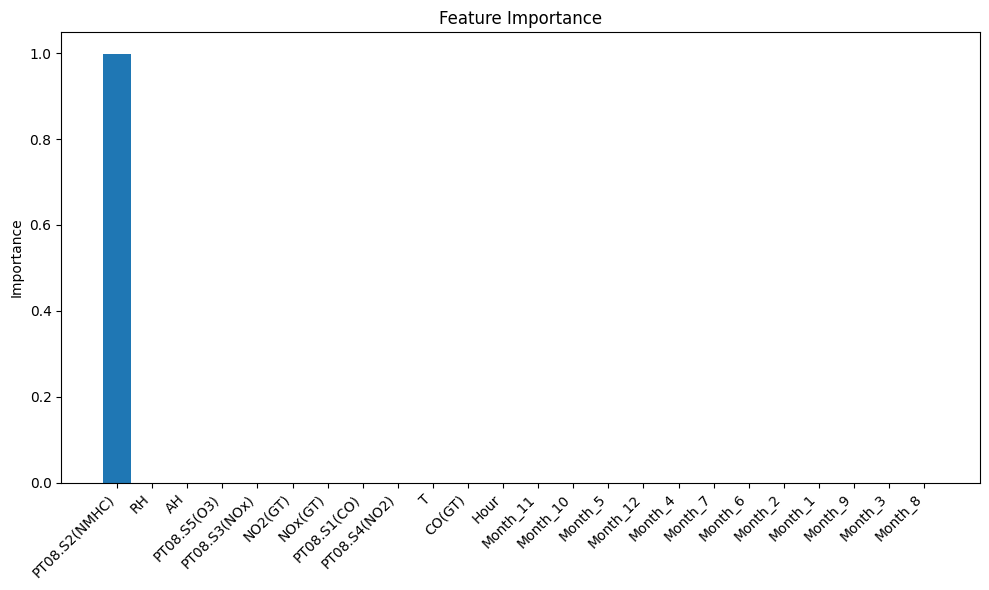

In [ ]:
feature_importances = dtr2.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance Decision Tree1')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

From feature importance plot can be concluded that the only feature on which our model relies on is PT08.S2(NMHC), this feature as noted before had the highest linear correlation (almost perfect) with target feature, so it is natural that decision tree also heavily relies on this feature while predicting target. This plot backs derived conclusions from earlier seen plot of "short" decision tree. All other features as can be seen do not contribute while predicting target. The feature importance plot could suggest us , that we could only use one feature for this regression task: "PT08.S2(NMHC)".

Let's build decision trees using dataset that does not contain feature "PT08.S2(NMHC)", just to investigate how good regressor we could get. In next section this feature is going to be dropped, all other Regressor models will also be trained on dataset that does not contain feature "PT08.S2(NMHC)". So, to investigate relationship between all other features and target feature.

In [ ]:
X_train_mod = X_train.drop('PT08.S2(NMHC)', axis=1)
X_test_mod = X_test.drop('PT08.S2(NMHC)', axis=1)

In [ ]:
dtr3 = train_test_Decision_Tree(X_train_mod, X_test_mod, y_train, y_test, 3)

Mean Absolute Error (MAE): 2.3569444444444447
R² Score: 0.7925785356750459


The variance of target variable explained by model is good, the MAE error is higher comparing to all other before seen models, but still is bearable. What needs to be taken into account is that the depth of the tree is small (is only equal to 3). Overall, metrics are the worst comparing to linear regression models and before seen tree based models. Metrics values of this decision tree regressor are similiar to metric values of second linear regression (as noted before , are worse).

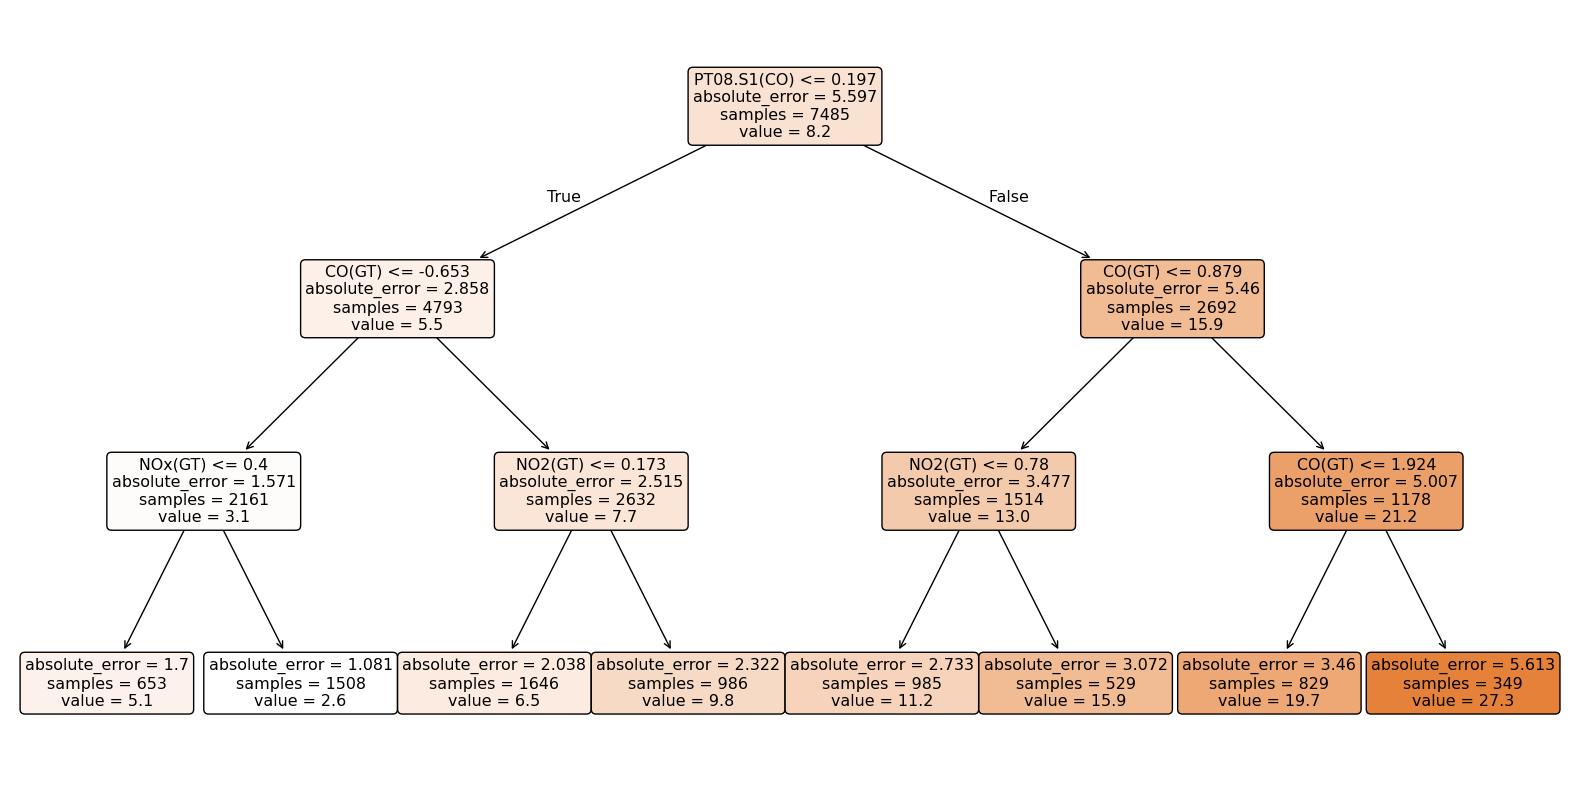

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(dtr3, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

Now the model relies also on other features to create splits. Features used in splitting are diverse and different(not solely one feature as was before). The root node splits using feature "PT08.S1(CO)" , which means that this variable is the most important among other from this dataset. Then the second by importance feature is CO(GT), as it is used in second layer of splitting nodes. Also, those seen variables in intenal nodes used for splitting had high correlations with target variable, all around value 0.9 (was investigated in EDA).

In [ ]:
dtr4 = train_test_Decision_Tree(X_train_mod, X_test_mod, y_train, y_test, 25)

Mean Absolute Error (MAE): 1.2116452991452993
R² Score: 0.9434199646712084


With increase of hyperparameter value, max_depth, model's perfomance improved, comparing to its previous version. MAE has decreased almost twice, and R^2 score increased significantly. This model already exceeded in perfomance second linear model.

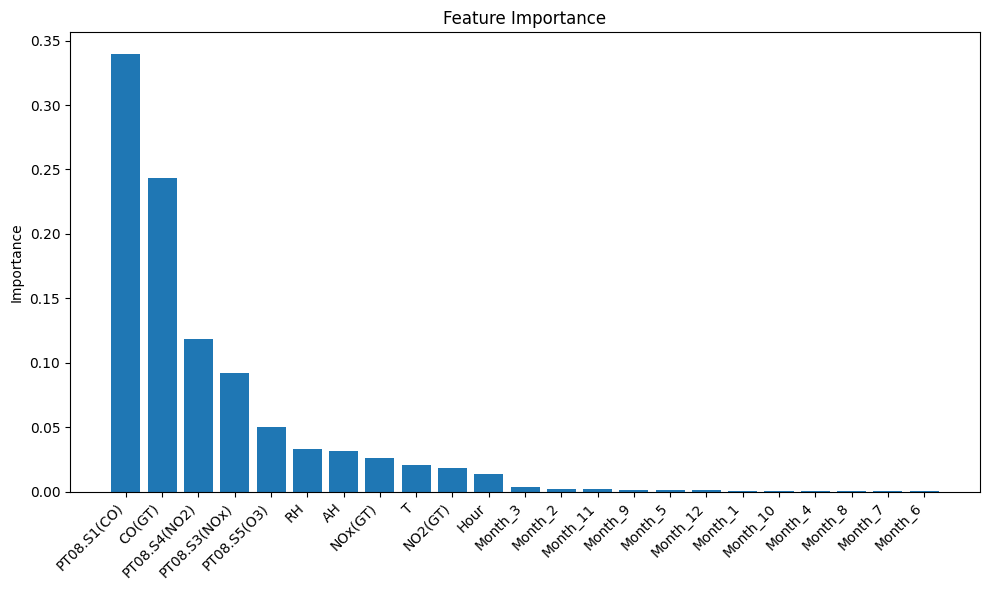

In [ ]:
feature_importances = dtr4.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_mod.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance Decision Tree2')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

As we can notice, features PT08.S1(CO), CO(GT), PT08.S4(NO2),  PT08.S3(NOx), PT08.S5(03) have the highest importance in our model. All except one of these features are derivatives of substance with prefix PT08 (as well the most correlated feature , that was deleted). This suggest, that in general chemical substance PT08 and its derivatives have direct impact on target feature. Features related to month indicators were not important. Out of features related to time, feature Hour was the most influencial.

In [ ]:
param_grid = {
    'max_depth': [5, 15, 25, 30, 50, 70, 100],
}

model = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_mod, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best R² Score: {best_score}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Parameters: {'max_depth': 15}
Best R² Score: 0.9267010010677028


Was chosen hyperparameter to tune "max_depth" , so to find the best maximum depth of the tree. Primarily, max_depth should be tuned as it has direct impact on the complexity of decision tree regressor model , so on the accuracy of predictions. As with an increase of this hyperparameter increases the risk that the model will overfit training data.  
Can be seen that the best hyperparameter found is: "max_depth"=15.

Conclusion:
The second Decision Tree regressor model (with "PT08.S2(NMHC)" and max_depth = 15) was even better than best linear model(first one), with MAE almost 10 times lower that for best linear regresssion model(marked as first).

The fourth decision tree performed better than linear regression model number two.

**Random Forest Regressor**

Defining function for training and testing Random Forest regressor.

In [ ]:
def train_test_Random_Forest(X_train, X_test, y_train, y_test, max_depth=10, n_estimators=5):
  model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, criterion="absolute_error")

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  mae = mean_absolute_error(y_test, y_pred)
  print(f"Mean Absolute Error (MAE): {mae}")
  r2 = r2_score(y_test, y_pred)
  print(f"R² Score: {r2}")

  return model

In [ ]:
rfr1 = train_test_Random_Forest(X_train_mod, X_test_mod, y_train, y_test)

Mean Absolute Error (MAE): 0.9688675213675214
R² Score: 0.9656676099265852


Can be seen that baseline random forest regressor with parameters (max_depth = 10, n_estimators = 5) got very good results, MAE error is 0.96 , which is very small. Also the R^2 is very high , equals to 0.96.

In [ ]:
rfr2 = train_test_Random_Forest(X_train_mod, X_test_mod, y_train, y_test, 20, 15)

Mean Absolute Error (MAE): 0.8040438034188034
R² Score: 0.9758376310547867


Change of hyperparameters performed (max_depth increased from 5 to 20 and number of estimators increased from 5 to 15). Metrics became better comparing to previous random forest regressor, but the improvement in R^2 metric is not crytical, just one percent. The MAE error decrease is considerable(decreased by approximately 0.16 units)

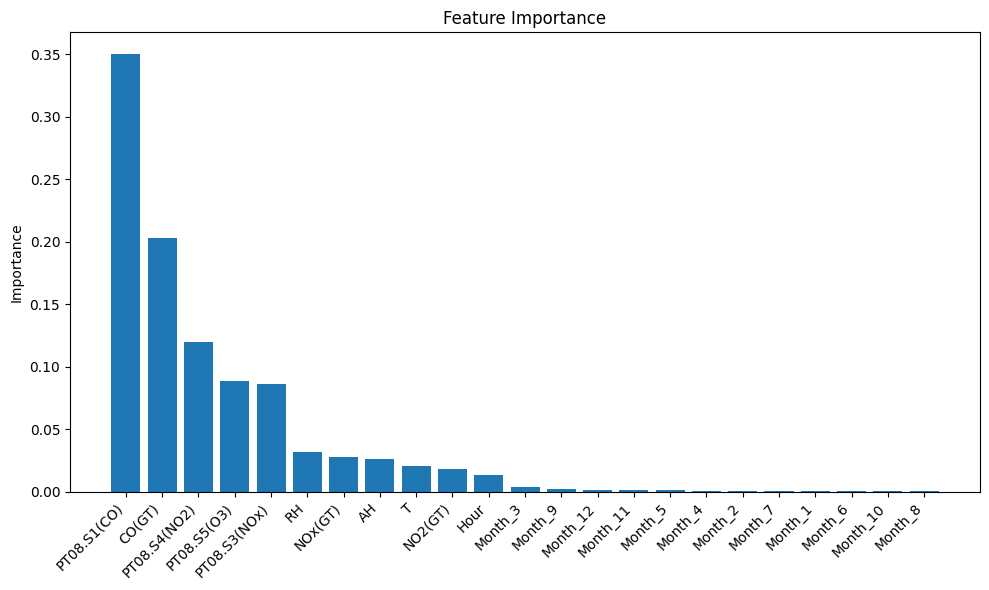

In [ ]:
feature_importances = rfr2.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_mod.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

Almost the same feature importance plot was seen for decision tree before(very similiar, some fetaures have swapped the positions with neigbours). Most influencial features are the same(From family of "PT08"). Though forest regressor gave in this case almost the same weight to PT08.S5(O3) and PT08.S3(NOx)(had different weights in decision trees). In this case , forest regressor also did not make use of "month" features, meaning that these features are not very important in our situation. As well, the feature Hour has higher importance than all Month related features.

In [ ]:
param_grid = {
    'n_estimators': [20, 30, 40],
    'max_depth': [20, 25, 15],
}

model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train_mod, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best R² Score: {best_score}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': 15, 'n_estimators': 30}
Best R² Score: 0.9679238813668313


Primarily will be regarded most influencial for random forest regressor hyperparameters: n_estimators (number of built trees) and max_depth (maximum allowed depth of one particular tree), as they mostly influence bias and variance of overall model. n_estimators parameter is responsible for number of trees built in ensemble and max_depth is responsible for maximum allowable depth that one particular tree can reach.   
As can be seen best perfomance shows the model with hyperparameters: max_depth = 15, n_estimators = 30.

In [ ]:
rfr3 = train_test_Random_Forest(X_train_mod, X_test_mod, y_train, y_test, 15, 30)

Mean Absolute Error (MAE): 0.7692459045584047
R² Score: 0.9780233058380047


Comparing to before seen random forest regressors, tunned version shows the best perfomance, with the smallest MAE error and the highest R^2 score.
There was little difference of R^2 score across all random forest regressors, it was almost the same for all random forest models.

Random Forest models were trained on dataset that did not contain feature "PT08.S2(NMHC)". So, these models will be compared to all other models (regression, decision trees) which also were trained without that feature.
Comparing random forest regressors to all othe models:  
1) All Random Forest models had MAE error approximately three times lower than for Linear Regression model. R^2 was also significantly higher for random forests(around 0.97) comparing to R^2 of Linear Regression (0.82).  
2) All random forests performed better than decision trees. The gap is not as big (comparing to gap between random forests and linear regression), but still is observable.

**XGBoost Regression**

Defining function for training and testing XGBoost regressor.

In [ ]:
def train_test_xgboost(X_train, X_test, y_train, y_test, max_depth=3, n_estimators=100, alpha=0):
    model = XGBRegressor(max_depth = max_depth, n_estimators = n_estimators, alpha=alpha)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"R² Score: {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return model

In [ ]:
xgb1 = train_test_xgboost(X_train_mod, X_test_mod, y_train, y_test)

R² Score: 0.9797023777501619
Mean Absolute Error (MAE): 0.7890221791835422


Baseline XGBoost regressor showed pretty good results, the percentage of target variable variance explained is around 97%, MAE is relatively small 0.78. Baseline classifier had such hyperparameters: maximum allowed depth to which each tree can grow was only 3; (n_estimators) number of built weak learners is 100, meaning that overall was built 100 trees.

In [ ]:
xgb2 = train_test_xgboost(X_train_mod, X_test_mod, y_train, y_test, 10, 200)

R² Score: 0.9802893224239461
Mean Absolute Error (MAE): 0.7182964070325988


After increasing maximum depth parameter(from 3 to 10) and number of estimators parameter (from value 100 to 200), the perfomance of regressor improved, though the difference is not huge. R^2 scored increased only by 0.1% and MAE decreased by around 0.07 units. Taking into account the fact that metrics have not improved significantly , can be concluded that there is no need to use such a complex version of XGBoost for solving this problem.

In [ ]:
xgb3 = train_test_xgboost(X_train_mod, X_test_mod, y_train, y_test, 10, 200, 5)

R² Score: 0.9821315972476753
Mean Absolute Error (MAE): 0.6860154718733752


For this XGBoost regressor was also applied L1 regularization(all other hyperparameters are the same as for previous XGBoost regressor), the regularization parameter was set to relatively moderate value. Comparing to previous model we see that R^2 score became a little bit bigger and significant change was in MAE error, it decreased by approximately 0.3 units. We see that adding reguralization decreased MAE error, R^2 score almost did not change.

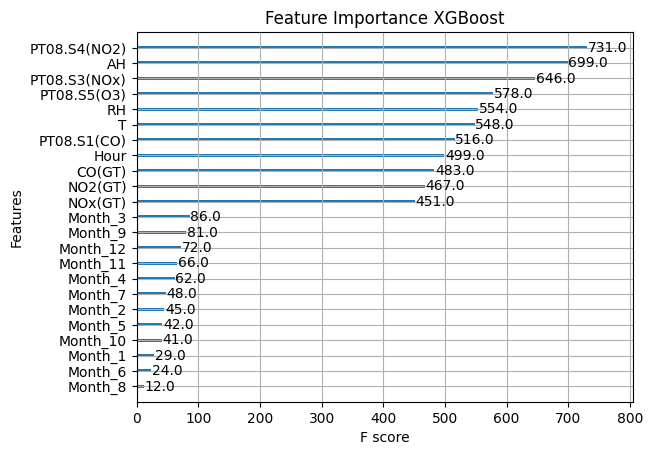

In [ ]:
plot_importance(xgb3, importance_type='weight', title="Feature Importance XGBoost")
plt.show()

The most significant feature identified by XGBoost regressor is PT08.S4(NO2), which is different comparing to previous most important feature identified by Decision Tree and Random Forest (was previously PT08.S1(CO)).  
All regreessors (Decision Trees, Random Forests, XGBoost) do not rely heavily rely on Month related features. Out of all month features the most valuable for all regressors was Month_3.  
XGBoost identified feature Hour as pretty important, which was not spotted in cases of Random Forest Regressor and Decision Tree regressor.  
Still we see that chemicals from group "PT08" play vital role predicting target. But in this case also another factors came into play exceeding importance of some "PT08"s, those are: AH, RH, T. This relationship was not previously revealed by Decision Tree and Random Forest regressors.

In [ ]:
param_grid = {
    'max_depth': [10, 20],
    'n_estimators': [50, 100, 200],
    'reg_alpha': [0.1, 1, 5]
}

model = XGBRegressor()

grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,verbose=1,n_jobs=-1)

grid_search.fit(X_train_mod, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best R^2: {best_score}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 1}
Best R^2: 0.9730565828113354


In this case following same reasoning(which was described during hyperparameters tuning of random forest regressor), were tuned hyperparameters: max_depth, n_estimators. Also to model was added hyperparameter controlling reguralization power alpha, it will also be tuned. Setting this hyperparameter to higher values, results in making weights estimated by xgboost deminish. It was added to investigate if reguralization would have any positive effect on model.

**Conclusion**

***The best model that did make use of feature "PT08.S2(NMHC)" (target variable had almost perfect dependency with this feature):***  
Decision Tree Regressor (max_depth=15) with MAE: 0.02 and R^2: 0.99.

***The best model that did not make use of feature "PT08.S2(NMHC)":***  
XGBoost Regressor (max_depth=10, n_estimators=200, alpha=5) with MAE: 0,68 and R^2: 0,98.

Best regressor from each regressor family regarded in this notebook:  
The best Decision Tree Regressor (not using "PT08.S2(NMHC)") (max_depth=25) with MAE: 1,2 and R^2: 0,94.  
The best Random Forest Regressor (not using "PT08.S2(NMHC)") (max_depth=15, n_estimators=30) with MAE: 0,7 and R^2: 0,97.  
The best XGBoost regressor (not using "PT08.S2(NMHC)") (max_depth=10, n_estimators=200, alpha=5) with MAE: 0,68 and R^2: 0,98.  

Comparing to linear model all regressors (Decision Trees, Random Forests, XGBoost regressors) built in this work did much better, had much higher R^2 scores and much lower MAE errors.

Also, were identified important features for predicting target variable, those are: chemicals from family "PT08".